# Convolutional neural network: Sign language digit recognizer

We build a convolutional neural network to create multiclass sign language digit recognizer from hand sign images. We use the TensorFlow (TF) Keras Functional API.

## 1 - Packages

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

## 2 - The Functional API

We will use Keras' flexible [Functional API](https://www.tensorflow.org/guide/keras/functional) to build a ConvNet that can differentiate between 6 sign language digits. 

The Functional API can handle models with non-linear topology, shared layers, as well as layers with multiple inputs or outputs. Whereas the Sequential API requires the model to move in a linear fashion through its layers, the Functional API allows much more flexibility. A Sequential model is a straight line, but a Functional model is a graph, where the nodes of the layers can connect in multiple different ways. 

In the example below, a skip connection is added to a Sequential model, which is just one of the many ways a Functional model can be constructed. A skip connection skips some layer in the network and feeds the output to a later layer in the network.

<img src="images/seq_vs_func.png" style="width:350px;height:200px;">

### 2.1 - Load the SIGNS Dataset

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [13]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

<img src="images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset.

y = 4


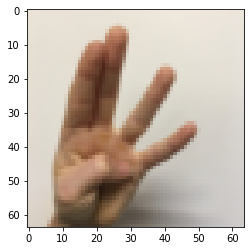

In [14]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### 2.2 - Split the data into train/test sets

It is possible to build a fully-connected neural network for this dataset. But since this is an image dataset, it is more natural to apply a ConvNet to it.

To get started, let's examine the shapes of your data. 

In [15]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 2.3 - Forward propagation

In TensorFlow, there are built-in functions that implement the convolution steps for you. In the [Functional API](https://www.tensorflow.org/guide/keras/functional), you create a graph of layers. This is what allows such great flexibility. However, the following model could also be defined using the Sequential API since the information flow is on a single line.

Begin building your graph of layers by creating an input node that functions as a callable object:

- **input_img = tf.keras.Input(shape=input_shape):** 

Then, create a new node in the graph of layers by calling a layer on the `input_img` object: 

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Read the full documentation on [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, you usually operate on a single example at a time and a single channel at a time. Read the full documentation on [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the elementwise ReLU of Z (which can be any shape). You can read the full documentation on [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 x 3 x 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In the last function above (`tf.keras.layers.Dense()`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

Lastly, before creating the model, you'll need to define the output using the last of the function's compositions (in this example, a Dense layer): 

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)**

The words "kernel" and "filter" are used to refer to the same thing. The word "filter" accounts for the amount of "kernels" that will be used in a single convolution layer. "Pool" is the name of the operation that takes the max or average value of the kernels. 

This is why the parameter `pool_size` refers to `kernel_size`, and you use `(f,f)` to refer to the filter size. 

Pool size and kernel size refer to the same thing in different objects - They refer to the shape of the window where the operation takes place. 

We implement the `convolutional_model` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Use the functions above! 

We use the following parameters:
 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 4 by 4 filters, stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 2 by 2 filters, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 6 neurons and a softmax activation. 

In [29]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)

    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters=8, kernel_size=4, strides=1, padding='same')(input_img)
    
    # RELU
    A1 = tfl.ReLU()(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding='same')(A1)

    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters=16, kernel_size=2, strides=1, padding='same')(P1)
    
    # RELU
    A2 = tfl.ReLU()(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='same')(A2)
    
    # FLATTEN
    F = tfl.Flatten()(P2)
    
    # Dense layer
    # 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(units=6, activation='softmax')(F)    
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    
    return model

In [30]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(conv_model), output)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 2, 16)         

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model. 

### 2.4 - Train the model

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 2s 101ms/step - loss: 1.8576 - accuracy: 0.1611 - val_loss: 1.7994 - val_accuracy: 0.1750
Epoch 2/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7964 - accuracy: 0.1574 - val_loss: 1.7926 - val_accuracy: 0.1250
Epoch 3/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7915 - accuracy: 0.1796 - val_loss: 1.7894 - val_accuracy: 0.2083
Epoch 4/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7887 - accuracy: 0.2009 - val_loss: 1.7875 - val_accuracy: 0.1833
Epoch 5/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7873 - accuracy: 0.2093 - val_loss: 1.7864 - val_accuracy: 0.1917
Epoch 6/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7861 - accuracy: 0.2176 - val_loss: 1.7849 - val_accuracy: 0.2500
Epoch 7/100
17/17 [==============================] - 2s 100ms/step - loss: 1.7848 - accuracy: 0.2556 - val_loss: 1.7840 - val_accuracy: 0.2250

## 3 - History object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It is stored as a dictionary that you can retrieve at `history.history`: 

In [32]:
history.history

{'loss': [1.857597827911377,
  1.7963767051696777,
  1.7914661169052124,
  1.788659930229187,
  1.7873340845108032,
  1.786102533340454,
  1.7848069667816162,
  1.7831716537475586,
  1.7815375328063965,
  1.7794910669326782,
  1.7768654823303223,
  1.7743785381317139,
  1.7703126668930054,
  1.765395998954773,
  1.7590385675430298,
  1.7496048212051392,
  1.737260341644287,
  1.7174746990203857,
  1.6921570301055908,
  1.6599516868591309,
  1.618006944656372,
  1.5705699920654297,
  1.5218685865402222,
  1.4734255075454712,
  1.4268568754196167,
  1.3796082735061646,
  1.3366483449935913,
  1.294775366783142,
  1.256098985671997,
  1.2201366424560547,
  1.184395432472229,
  1.1502509117126465,
  1.1179616451263428,
  1.0878896713256836,
  1.059814453125,
  1.0323723554611206,
  1.0069594383239746,
  0.9821946620941162,
  0.9592660665512085,
  0.936527669429779,
  0.9160501956939697,
  0.8945029377937317,
  0.8733409643173218,
  0.8530988693237305,
  0.8322245478630066,
  0.811051487922

Now visualize the loss and accuracy over time using `history.history`: 

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

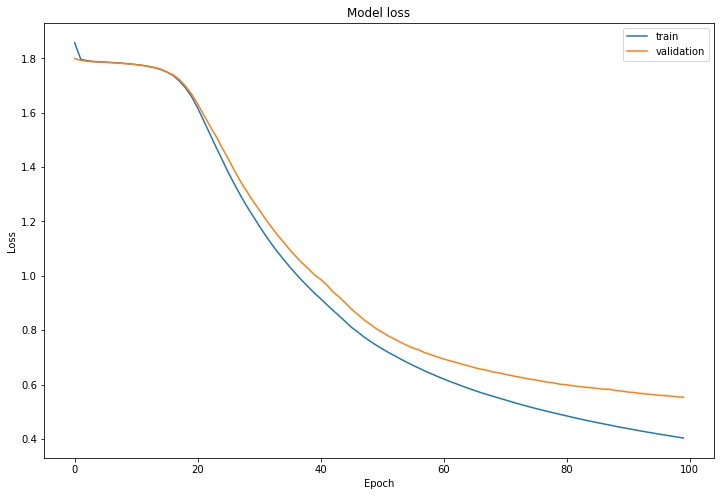

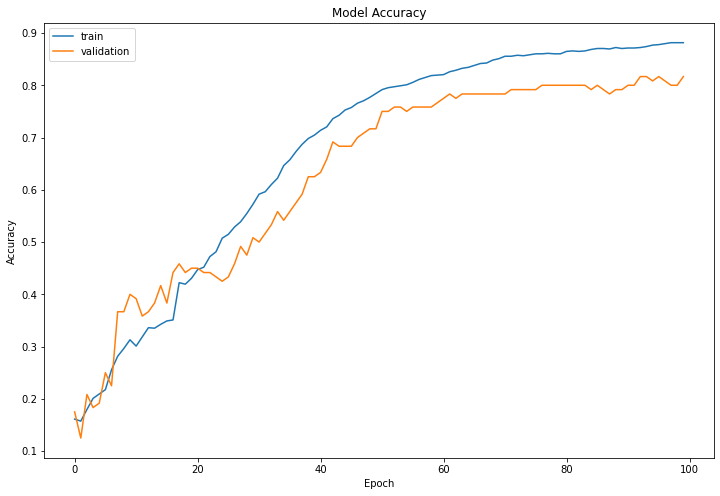

In [33]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

## 3 - Documentation

The official documentation for the Sequential and Functional APIs here: 

- [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model)
- [Functional API](https://www.tensorflow.org/guide/keras/functional)